# VanGo

#### When you're visiting a museum there is too much to see in a limited time. You have to make a choice, and there should be a way to take into account your personal interests. 

This is why I created a prototype of VanGo, a recommendation algorithm which takes a user input - in the prototype, a word - and searches through museum's collection to suggest most fitting art pieces. Below you will find the meat of the algorithm. 

I took advantage of experts' knowledge to extract information about the collection by harvesting curatorial descriptions. 

0. Quering SPARQL database to extract http addresses of all painitings in the collection (not included in this notebook)
1. loading JSON file with http addresses of paintings
2. scraping the http addresses and dumping html-s into one place
3. cleaning the htmls using REGEX and extracting the descriptions
4. Natural Language Processing - tokenizing, TFIDF, Vectorizer
5. Principal Component Analysis
6. Projecting vectorized descriptions onto PCA space
7. Saving the results 

# Importing 

In [ ]:
import os
import nltk
import re
import pickle
import numpy as np
import pandas as pd

from spacy.en import English
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from stop_words import get_stop_words

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

import matplotlib.pyplot as plt

%matplotlib inline


## List of directories - fill them in

In [ ]:
curatorial_description_dump = os.listdir('')
physical_description_dump = os.listdir('')
image_dump = os.listdir('')
location_dump = os.listdir('')

### !!! feedback

* have one cell where import data 
* describe how data is structured [json files with http addresses].

In [114]:
def read_dump_to_lookup(data_dump):
    '''
    reads from a list of file names and creates a dictionary in which
    keys are file names and values are the content of those files. 
    File names are unique and are http addresses of the original source.
    
    included brute error handling to manage corrupt data 
    '''
    lookup = {}
    for i, dump in enumerate(data_dump):
        file_name = data_dump[i]
        try:
            with open(file_name, 'r') as f:
                lookup[file_name] = f.read()
        except:
            pass
    return lookup

In [ ]:
curatorial_description_lookup = read_dump_to_lookup(curatorial_description_dump)
image_lookup = read_dump_to_lookup(image_dump)
physical_descriptions_lookup = read_dump_to_lookup(physical_descriptions_lookup)
location_lookup = read_dump_to_lookup(location_lookup)

# Data cleaning 

In [10]:
my_dict = {'a', 'b', 'c'}
your_dict = {'b', 'c', 'd'}
their_dict = {'a', 'b', 'd'}
h = [my_dict,your_dict,their_dict]

## Add function 

In [9]:
def ensure_all_fields_present(t,data_lookups):

shared_dictionary = my_dict.intersection(your_dict, their_dict)



{'b'}

In [142]:
print set(curatorial_descriptions_lookup.keys())-set(physical_descriptions_lookup.keys())
print set(physical_descriptions_lookup.keys())-set(curatorial_descriptions_lookup.keys())
print set(image_lookup.keys())-set(curatorial_descriptions_lookup.keys())

set([])
set([])
set([])


In [127]:
#paintings dataset
del physical_descriptions_lookup['http:__collection.britishmuseum.org_id_object_234114']
del curatorial_descriptions_lookup['http:__collection.britishmuseum.org_id_object_233926']
del curatorial_descriptions_lookup['http:__collection.britishmuseum.org_id_object_R_1984-0203-0-11-b']
del image_lookup['http:__collection.britishmuseum.org_id_object_R_1984-0203-0-11-b']
del image_lookup['http:__collection.britishmuseum.org_id_object_233926']


In [21]:
#drawings dataset

del physical_descriptions_lookup['http:__collection.britishmuseum.org_id_object_P_1842-0806-373']
del physical_descriptions_lookup['http:__collection.britishmuseum.org_id_object_GAA88165']
del physical_descriptions_lookup['http:__collection.britishmuseum.org_id_object_3364045']
del physical_descriptions_lookup['http:__collection.britishmuseum.org_id_object_PDO13226']

del curatorial_descriptions_lookup['http:__collection.britishmuseum.org_id_object_1430470']
del curatorial_descriptions_lookup['http:__collection.britishmuseum.org_id_object_P_1871-1209-6287']
del curatorial_descriptions_lookup['http:__collection.britishmuseum.org_id_object_3420068']
del curatorial_descriptions_lookup['http:__collection.britishmuseum.org_id_object_GAA87550']
del curatorial_descriptions_lookup['http:__collection.britishmuseum.org_id_object_GAA87533']

del image_lookup['http:__collection.britishmuseum.org_id_object_1430470']
del image_lookup['http:__collection.britishmuseum.org_id_object_GAA87533']
del image_lookup['http:__collection.britishmuseum.org_id_object_GAA88165']
del image_lookup['http:__collection.britishmuseum.org_id_object_P_1871-1209-6287']
del image_lookup['http:__collection.britishmuseum.org_id_object_PDO13226']
del image_lookup['http:__collection.britishmuseum.org_id_object_GAA87550']


# Tokenizing and stemming

In [ ]:
p_stemmer = PorterStemmer()
tokenizer = RegexpTokenizer(r'\w+[a-z]')
en_stop = get_stop_words('en')

def tokenizing_stemming(curatorial_description):
    '''
    function to tokenize and stem long descriptions
    
    input: string (single curatorial description)
    output: list of strings (stemmed tokens)
    '''
    #TOKENIZING
    stringed=str(curatorial_description)
    tokens = tokenizer.tokenize(stringed)
    raw = stringed.lower()
    tokens = tokenizer.tokenize(raw)

    #REMOVING STOP WORDS
    # create English stop words list
    # remove stop words from tokens
    stopped_tokens = [i for i in tokens if not i in en_stop]

    #STEMMING
    # stem token
    stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    stemmed_tokens = ' '.join(stemmed_tokens)

    return stemmed_tokens

#TO DO: remove words such as "span" "div" "british museum" and maybe also first and last names

def cleaning_images_finding_http(images_text):
    '''
    function which pulls out the http address for image corresponding to description
    
    input: string (long string from a website)
    output: string (http address pointing to an image)
    '''
    if images_text !="None":
        pull_out_http = re.split(" ",images_text)
        #print pull_out_http
        http_address = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',pull_out_http[3])
        http_address = http_address[0]
    else:
        http_address = "None"
    return http_address

def cleaning_htmltags_whitespace(text):
    '''
    function to strip html from tags (e.g. '\n'), extra spaces and unicode
    
    input: string (long html)
    output: sting (only description)
    '''
    new_text = re.sub(r"</?[a-zA-Z]*>", ' ',text)

    no_newlines = re.sub(r'\n',' ', new_text)
    no_unicode = re.sub(r'[^\x00-\x7F]+',' ', no_newlines)
    #print no_unicode
    no_extraspaces = re.sub(r"\s{2,}",' ',no_unicode)
    no_search = re.sub(r"None", '',no_extraspaces)
    
    return no_search

def spacy_tokenizer_lemmatizer(text):
    """
    Take a unicode string of text and return a list containing the lemmatized tokens
    Output: list of lemmatized tokens
    """
    parsed_data = parser(text)
    list_of_lemmatized_tokens = [token.lemma_ for token in parsed_data]
    return list_of_lemmatized_tokens

## return to it later

### reason for not pulling out the values from the dictionary: .values() scrambles the order which would mess up the attempt to .join() later

In [143]:
not_cleaned_description_pairs_p=[]
for link, curatorial_desription in physical_descriptions_lookup.iteritems():
    try:
        not_cleaned_description_pairs_p.append((link, curatorial_desription))
    except Exception as e:
        print e.message

not_clean_descriptions_physical = [pair[1] for pair in not_cleaned_description_pairs_p]

In [144]:
not_cleaned_description_pairs_c=[]
for link, curatorial_desription in curatorial_descriptions_lookup.iteritems():
    try:
        not_cleaned_description_pairs_c.append((link, curatorial_desription))
    except Exception as e:
        print e.message

not_clean_descriptions_curatorial = [pair[1] for pair in not_cleaned_description_pairs_c]

In [130]:
not_cleaned_images=[]
for link, image in image_lookup.iteritems():
    try:
        not_cleaned_images.append((link, image))
    except Exception as e:
        print e.message

images_ = [pair[1] for pair in not_cleaned_images]

In [131]:
links = []
for image in images_:
    links.append(cleaning_images_finding_http(image))

In [133]:
#links = [tup[0] for tup in not_cleaned_description_pairs_c]
descriptions = [tup[1] for tup in not_cleaned_description_pairs_c]


In [698]:
not_cleaned_description_pairs_c[103]

('http:__collection.britishmuseum.org_id_object_R_1965-1011-0-1',
 '<div>\n<span><span>Rawson 1992:\n\nWen Zhengming was the leading amateur-literati painter of the 16th century and, with Shen Zhou (1427-1509), one of the principal artists of the Wu school of the scholars-officials. Both of them looked back to the work of the Yuan masters and were preoccupied with the identification of different forms of brushwork as suitably expressive for different occasions. \n\nThis painting was said by him to have been inspired by the work of Li Cheng, a tenth-century landscape artist. Its spare, rather dry brushwork again repeats the deliberately simple, austere quality that is the feature of many so-called literati paintings.</span></span>\n</div>')

## join physical and curatorial descriptions 

In [147]:
joined_descriptions = map("".join,zip(not_clean_descriptions_curatorial,not_clean_descriptions_physical))

In [148]:
clean_description=[]
for curatorial_physical in joined_descriptions:
    clean_description.append(cleaning_htmltags_whitespace(curatorial_physical))


In [636]:
clean_description[28345:28350]

[' Dallapiccola 2010: This painting, as in other drawings in this series, conveys a remarkable sense of space. This painting comes from an album of fifteen paintings (2005,0716,0.1.1-15) illustrating scenes somewhat different from those usually included in trade and occupation albums. The drawings are carefully executed, with great attention to detail. The palette is vivid without being garish, and gold is lavishly used in the rendering of jewellery, sari borders and, among others, the shrine in 2005,0716,0.1.3. The artist proudly displays his versatility in 2005,0716,0.1.6 and 2005,0716,0.1.8; these works imitate the Deccani and Mughal styles respectively. , South Indian paintings have been much less studied than have paintings from the north Indian schools. Nevertheles, the holdings of the museum are over 800 in number and of interest - particularly with respect to a forthcoming BMP publication on south Indian paintings in the British Museum (by A. Dallapiccola). Opaque watercolour p

In [40]:
with open('joined_cleaned_descriptions_drawings','w') as f:
    pickle.dump(clean_description,f)

In [186]:
clean_description_=clean_description[20000:]

In [692]:
clean_description[103]

' Rawson 1992: Wen Zhengming was the leading amateur-literati painter of the 16th century and, with Shen Zhou (1427-1509), one of the principal artists of the Wu school of the scholars-officials. Both of them looked back to the work of the Yuan masters and were preoccupied with the identification of different forms of brushwork as suitably expressive for different occasions. This painting was said by him to have been inspired by the work of Li Cheng, a tenth-century landscape artist. Its spare, rather dry brushwork again repeats the deliberately simple, austere quality that is the feature of many so-called literati paintings. Hanging scroll. Landscape. Bare trees in winter, with reference to Li Cheng (919-67) and a river. Painted in a very dry style. Inscriptions and seals. Ink on paper '

In [187]:
parser = English()
tokenized_descriptions=[]
for description in clean_description_:
    #try:
    tokenized_descriptions.append(spacy_tokenizer_lemmatizer(unicode(description)))
#     except:
#         pass


In [181]:
with open('tokenized_descriptions_drawings_paintings', 'r') as g:
    tddp = pickle.load(g)

In [170]:
links = links_paintings + links_drawings

In [699]:
tokenized_descriptions[103]

[u' ',
 u'painting',
 u'.',
 u'landscape',
 u'.',
 u'devotion',
 u'.',
 u'scene',
 u'from',
 u'forest',
 u'life',
 u'include',
 u'worship',
 u'at',
 u'a',
 u'shrine',
 u'.',
 u'wash',
 u'in',
 u'dung',
 u'(',
 u'cow',
 u'in',
 u'solution',
 u')',
 u'and',
 u'paint',
 u'in',
 u'white',
 u'on',
 u'paper',
 u'(',
 u'brown',
 u')',
 u'.',
 u'sign',
 u'.']

In [179]:
with open('links_paintings_drawings','w') as f:
    pickle.dump(links,f)

In [189]:
with open('tokenized_descriptions_paintings_20000+','w') as f:
    pickle.dump(tokenized_descriptions,f)

[u' ', u'the', u'manual', u'be', u'compose', u'of', u'141', u'sheet', u'by', u'prince', u'pu', u'quan', u'and', u'katherine', u'talati', u';', u'ink', u'or', u'ink', u'and', u'colour', u'on', u'paper', u'or', u'silk', u';', u'show', u'motif', u'to', u'compose', u'landscape', u'.', u'the', u'sheet', u'be', u'loose', u'and', u'store', u'in', u'a', u'brocade', u'box', u',', u'apart', u'from', u'three', u'which', u'be', u'frame', u'.', u'paint', u'(', u'one', u'of', u'138', u'sheet', u'keep', u'in', u'brocade', u'box', u')', u'.', u'texture', u'stroke', u'for', u'rock', u'and', u'mountain', u'peak', u';', u'ink', u'on', u'paper', u';', u'from', u'a', u'painting', u'manual', u'.', u'pencil', u'note', u"'", u'dian', u'(', u'dot', u')', u'-', u'wrinkle', u'-', u'shape', u'line', u"'", u'on', u'back', u'.']
12250


In [259]:
tokenized_descriptions_paintings = tokenized_20000 + tokenized_20000_

In [262]:
with open('tokenized_descriptions_drawings_all', 'r') as g:
    tokenized_descriptions_drawings = pickle.load(g)
#tokenized_paintings_all=tokenized_descriptions + tokenized_20000

In [263]:
tokenized_descriptions_paintings_drawings = tokenized_descriptions_paintings + tokenized_descriptions_drawings

In [693]:
print tokenized_descriptions_paintings_drawings[103]
links[31111]

[u' ', u'rawson', u'1992', u':', u'wen', u'zhengming', u'be', u'the', u'lead', u'amateur', u'-', u'literati', u'painter', u'of', u'the', u'16th', u'century', u'and', u',', u'with', u'shen', u'zhou', u'(', u'1427', u'-', u'1509', u')', u',', u'one', u'of', u'the', u'principal', u'artist', u'of', u'the', u'wu', u'school', u'of', u'the', u'scholar', u'-', u'official', u'.', u'both', u'of', u'them', u'look', u'back', u'to', u'the', u'work', u'of', u'the', u'yuan', u'master', u'and', u'be', u'preoccupy', u'with', u'the', u'identification', u'of', u'different', u'form', u'of', u'brushwork', u'as', u'suitably', u'expressive', u'for', u'different', u'occasion', u'.', u'this', u'painting', u'be', u'say', u'by', u'him', u'to', u'have', u'be', u'inspire', u'by', u'the', u'work', u'of', u'li', u'cheng', u',', u'a', u'tenth', u'-', u'century', u'landscape', u'artist', u'.', u'its', u'spare', u',', u'rather', u'dry', u'brushwork', u'again', u'repeat', u'the', u'deliberately', u'simple', u',', u'aust

'http://www.britishmuseum.org/collectionimages/AN01034/AN01034144_001_l.jpg'

In [258]:
len(tokenized_20000_)

12250

In [274]:
with open('tokenized_descriptions_paintings_drawings','w') as f:
    pickle.dump(tokenized_descriptions_paintings_drawings,f)

In [138]:
cd Desktop

/Users/virginiakinniburgh/Desktop


In [212]:
with open('links_paintings_drawings', 'r') as g:
    links_ = pickle.load(g)
    
with open('joined_token_list_paintings_drawings', 'r') as t:
    tokens = pickle.load(t)


In [229]:
links_[32291]

'http://www.britishmuseum.org/collectionimages/AN01248/AN01248077_001_l.jpg'

In [207]:
len(joined_token_list_paintings_drawings)

69787

In [100]:
tokenized_descriptions_ = dump2

In [97]:
with open('links_drawings','w') as f:
    pickle.dump(links,f)

In [275]:
joined_token_list=[]
for token_list in tokenized_descriptions_paintings_drawings:
    joined_token_list.append(" ".join(token_list))

In [276]:
joined_token_list_paintings_drawings = joined_token_list

In [700]:
print joined_token_list_paintings_drawings[103]
print links[2257]

  rawson 1992 : wen zhengming be the lead amateur - literati painter of the 16th century and , with shen zhou ( 1427 - 1509 ) , one of the principal artist of the wu school of the scholar - official . both of them look back to the work of the yuan master and be preoccupy with the identification of different form of brushwork as suitably expressive for different occasion . this painting be say by him to have be inspire by the work of li cheng , a tenth - century landscape artist . its spare , rather dry brushwork again repeat the deliberately simple , austere quality that be the feature of many so - call literati painting . hang scroll . landscape . bare tree in winter , with reference to li cheng ( 919 - 67 ) and a river . paint in a very dry style . inscription and seal . ink on paper
http://www.britishmuseum.org/collectionimages/AN00980/AN00980334_001_l.jpg


## TFIDF and VECTORIZER

In [104]:


# vectorizer = CountVectorizer(max_df=0.95, min_df=2,
#                                 stop_words='english')
# document_matrix = vectorizer.fit_transform(joined_descriptions)

# from sklearn.feature_extraction.text import TfidfTransformer
# from sklearn.feature_extraction.text import TfidfTransformer
# transformer = TfidfTransformer()
# document_matrix_tfidf = transformer.fit_transform(document_matrix)




#spacys = spacy_tokenizer_lemmatizer(text_)
#print time.time()-time_start
vectorizer = TfidfVectorizer(min_df=0.005, max_df=0.5, stop_words='english')
#max_ngram = 1

#vectorizer = TfidfVectorizer(min_df=min_df,
#                ngram_range=(1, max_ngram), tokenizer=spacy_tokenizer_lemmatizer)
#vectorizer = TfidfVectorizer(min_df=5, tokenizer=spacy_tokenizer_lemmatizer)




In [284]:
document_matrix_tfidf = vectorizer.fit_transform(joined_token_list)

In [702]:
document_matrix_tfidf

<1x959 sparse matrix of type '<type 'numpy.float64'>'
	with 27 stored elements in Compressed Sparse Row format>

In [285]:
#print tfidf.toarray()
#print transformer.idf_ 
#print vectorizer.get_feature_names()
len(vectorizer.get_feature_names())

959

## PCA

In [286]:


document_matrix_tfidf = normalize(document_matrix_tfidf, norm='l2', axis=1, copy=True)

pca = PCA(n_components=10)
pca.fit(document_matrix_tfidf.toarray())
PCA(copy=True, n_components=10, whiten=False)
print(pca.explained_variance_ratio_) 

[ 0.03581674  0.02250942  0.02048105  0.01735392  0.01464428  0.01264963
  0.01169498  0.01109378  0.01055545  0.00986216]


In [287]:
document_matrix_tfidf.shape

(69787, 959)

## Variance explaiend


In [288]:
sum(pca.explained_variance_ratio_)

0.16666140560859297

In [289]:
document_matrix_pca_transformed = pca.transform(document_matrix_tfidf.toarray())



## Normalize

In [ ]:
document_matrix_pca_transformed_norm = normalize(document_matrix_pca_transformed, norm='l2', axis=1, copy=True)

In [500]:
document_matrix_pca_transformed_norm.shape

(69787, 10)

## Cosine similarity

In [290]:
#numpy.dot(input_projection_pca, document_matrix_pca_transformed_norm(painting, :))
#    for painting in document_matrix_pca_transformed]

#for painting in document_matrix_pca_transformed
#    similarity_score = numpy.dot(input_projection_pca, document_matrix_pca_transformed(painting, :)
                                 
def cosine_similarity(array2):
    return np.dot(input_project)

In [805]:
pca_components = pca.components_
print pca_components.shape
feature_list = vectorizer.get_feature_names()
print feature_list
#index_feature = feature_list.index(input_word)
#input_projection_pca = pca_components[:,index_feature]

(10, 959)
[u'0323', u'0617', u'0704', u'0713', u'10', u'102', u'11', u'12', u'121', u'1210', u'136', u'138', u'14', u'141', u'15', u'16', u'160', u'1637', u'17', u'179', u'1794', u'1795', u'18', u'1800', u'1805', u'1811', u'1814', u'1820', u'1855', u'1881', u'1886', u'18th', u'19', u'1913', u'1928', u'1929', u'1940', u'1974', u'1980', u'1981', u'1982', u'1987', u'1990', u'1992', u'1996', u'19th', u'1st', u'20', u'2003', u'2010', u'21', u'22', u'23', u'24', u'25', u'26', u'27', u'270', u'28', u'29', u'30', u'31', u'34', u'36', u'37', u'38', u'40', u'41', u'425', u'44', u'46', u'50', u'5006', u'55', u'60', u'65', u'74', u'79', u'91', u'99', u'abstract', u'accompany', u'accord', u'acquire', u'ad', u'add', u'additional', u'age', u'al', u'albert', u'album', u'altar', u'amid', u'amp', u'ancient', u'anderson', u'angel', u'animal', u'annotation', u'apart', u'apparently', u'appear', u'apply', u'approach', u'arch', u'architectural', u'architecture', u'area', u'arm', u'armed', u'armour', u'arrow'

In [292]:
print document_matrix_pca_transformed.shape
#print document_matrix_pca_transformed[0]

(69787, 10)


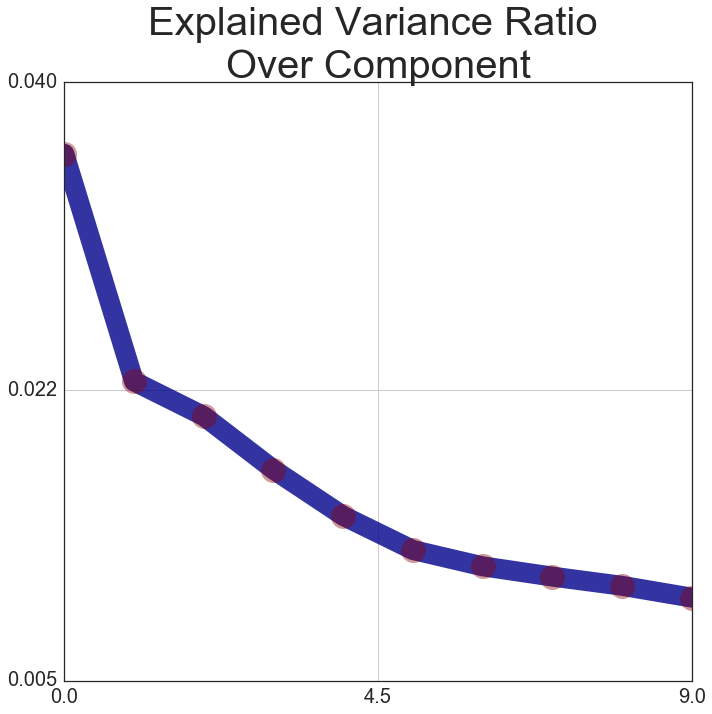

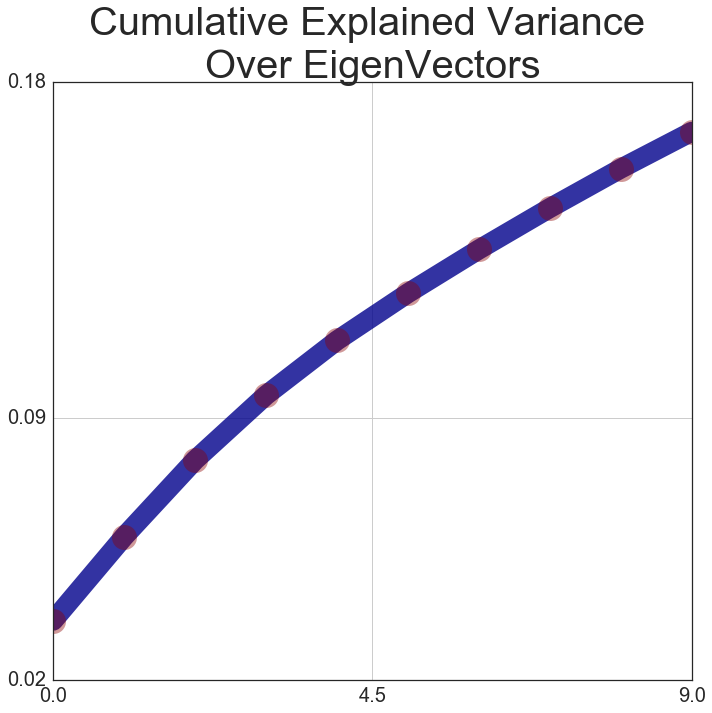

In [639]:
% matplotlib inline
import matplotlib as mlp
import matplotlib.pyplot as plt
#import seaborn as sns
plt.figure(figsize=(10, 10));
sns.set_style("white")
fontsize=20
title_fontsize=40
plt.title('Explained Variance Ratio \nOver Component',size=title_fontsize);
plt.plot(pca.explained_variance_ratio_,color="darkblue",linewidth=20,alpha=0.8);
plt.plot(pca.explained_variance_ratio_,'o',color="darkred",markersize=25,alpha=0.4);
plt.xticks(np.array([0,4.5,9]),size=fontsize)
plt.yticks(np.array([0.005,0.022,0.04]),size=fontsize)
plt.grid(True)
plt.tight_layout()
plt.show()
plt.figure(figsize=(10, 10));
plt.title('Cumulative Explained Variance \nOver EigenVectors',size=title_fontsize);
plt.plot(pca.explained_variance_ratio_.cumsum(),color="darkblue",linewidth=20,alpha=0.8);
plt.plot(pca.explained_variance_ratio_.cumsum(),'o',color="darkred",markersize=25,alpha=0.4);
plt.xticks(np.array([0,4.5,9]),size=fontsize)
plt.yticks(np.array([0.02,0.09,0.18]),size=fontsize)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
#links = [tup[0] for tup in not_cleaned_description_pairs_c]
#descriptions = [tup[1] for tup in not_cleaned_description_pairs_c]
similarity_df = pd.DataFrame({'link': links,
                              'description': joined_token_list,
                              'sim_score': similarity_score})

In [782]:
feature_list_df[0]

0             0323
1             0617
2             0704
3             0713
4               10
5              102
6               11
7               12
8              121
9             1210
10             136
11             138
12              14
13             141
14              15
15              16
16             160
17            1637
18              17
19             179
20            1794
21            1795
22              18
23            1800
24            1805
25            1811
26            1814
27            1820
28            1855
29            1881
          ...     
929      waterfall
930      watermark
931    watermarked
932            way
933           wear
934           west
935        western
936        whatman
937          white
938      whitfield
939           wide
940           wife
941        william
942         willow
943           wind
944       windmill
945         window
946           wing
947         winged
948          woman
949           wood
950         

In [809]:
pca_components_df = pd.DataFrame(pca_components)
pca_components_df.to_csv('pca_components_df.csv')

In [811]:
pca_components_recovered = pd.read_csv('pca_components_df.csv')

In [815]:
pca_components_recovered.iloc[:10, :10]
pca_components_recovered.values[:10, 1:11]

array([[ 0.00059847, -0.01142062,  0.03171647,  0.00821903, -0.00168707,
         0.00498687, -0.00171635, -0.00058854,  0.00380022, -0.03788069],
       [-0.00718576, -0.0408336 ,  0.10661479, -0.0033941 , -0.0044562 ,
        -0.01291075, -0.00826384, -0.00460518, -0.00471912,  0.00946394],
       [ 0.00724941,  0.06254547,  0.02089728, -0.00546361,  0.00794996,
        -0.00145075,  0.01401985,  0.00484794, -0.00330027, -0.02439894],
       [-0.01023512, -0.10646628, -0.01590463,  0.00494221, -0.00678834,
        -0.00968783, -0.0122846 , -0.0043441 , -0.00691407, -0.0093217 ],
       [ 0.00320369,  0.11544639,  0.02297807, -0.01362208, -0.00154111,
         0.01074264, -0.00309093, -0.00568462,  0.01984628,  0.00120751],
       [-0.00030342, -0.05286461,  0.01060169,  0.0167526 , -0.00508572,
         0.02439304, -0.00384134,  0.00119768, -0.01793743,  0.0116358 ],
       [ 0.00784491, -0.0407498 , -0.00873621, -0.05920405, -0.00599846,
         0.02435381, -0.0087383 , -0.00179492

In [768]:
feature_list = vectorizer.get_feature_names()
feature_list_df = pd.DataFrame(feature_list)
feature_list_df.to_csv('feature_list_df.csv')
pca_components_df = pd.DataFrame(pca_components)
pca_components_df.to_csv('pca_components_df.csv')
document_matrix_pca_transformed_norm_df = pd.DataFrame(document_matrix_pca_transformed_norm)
document_matrix_pca_transformed_norm_df.to_csv('document_matrix_pca_transformed_norm_df.csv')
links_df = pd.DataFrame(links_)
links_df.to_csv('links_df.csv')
joined_token_list_df = pd.DataFrame(joined_token_list)
joined_token_list_df.to_csv('joined_token_list_df.csv')

In [778]:
#feature_list = feature_list_df.to_list
#feature_list_df[0].values.tolist()
#type(pca_components)
simila

numpy.ndarray

In [808]:
print links_[0:10]
print feature_list[100:200]
print pca_components[:10,:10]
print pca_components_df.iloc[:10,:10]
print document_matrix_pca_transformed_norm[:10, :10]


['None' 'None' 'None'
 'http://www.britishmuseum.org/collectionimages/AN00539/AN00539168_001_l.jpg'
 'None' 'None' 'None' 'None' 'None'
 'http://www.britishmuseum.org/collectionimages/AN00071/AN00071343_001_l.jpg']
[u'apparently', u'appear', u'apply', u'approach', u'arch', u'architectural', u'architecture', u'area', u'arm', u'armed', u'armour', u'arrow', u'art', u'artist', u'arts', u'asahi', u'assemblage', u'associate', u'attach', u'attack', u'attendant', u'attribute', u'august', u'avalokite', u'away', u'background', u'bamboo', u'band', u'bank', u'banner', u'bare', u'bark', u'base', u'basket', u'battle', u'bear', u'beard', u'bearded', u'bed', u'begin', u'bell', u'belong', u'belt', u'beneath', u'berchem', u'bijutsu', u'bind', u'bird', u'birds', u'black', u'blank', u'blind', u'blossom', u'blue', u'bm', u'board', u'boat', u'bodhisattva', u'body', u'bodycolour', u'book', u'boot', u'border', u'bow', u'bowl', u'box', u'boy', u'branch', u'breast', u'bridge', u'bright', u'brilliant', u'bring',

In [825]:


def similarity(input_word):
    
    feature_list = vectorizer.get_feature_names()
    try:
        index_feature = feature_list.index(input_word)

        input_projection_pca = pca_components[:,index_feature]
        input_projection_pca = normalize(input_projection_pca, norm='l2', axis=1, copy=True)
    #print input_projection_pca

        def cosine_similarity(array2):
            return np.dot(np.squeeze(input_projection_pca), array2)
    
        similarity_score = np.apply_along_axis(cosine_similarity, axis=1, arr=document_matrix_pca_transformed_norm)
    #print similarity_score.shape
        links_=np.squeeze(links)

        similarity_df = pd.DataFrame({'link': links_,
                              'description': joined_token_list,
                              'sim_score': similarity_score})

        similarity_df_sorted = similarity_df.sort('sim_score', ascending=[0])

        deduplicated = similarity_df_sorted.drop_duplicates(['description'])
    #pd.options.display.max_colwidth = 2000
    
        deduplicated = deduplicated[deduplicated.link!='None']
        p  = deduplicated['link'].values.tolist()
    except:
        return "error_message"
    return p[0:10]

In [795]:
    print input_projection_pca

[[ 0.24802487 -0.1516156  -0.31298372  0.33696424 -0.01721526 -0.23507977
  -0.05452222  0.65008316 -0.44621891  0.15408339]]


In [838]:
h = similarity("jack")
print h
#if h in ["error_message"]
#    print "r"
answer = str(similarity("jack"))
if answer == "error_message":
  print("this will do the calculation")


error_message
this will do the calculation


In [662]:
np.linalg.norm(document_matrix_pca_transformed_norm[10, :])
#np.linalg.norm(input_projection_pca_)
links_=np.squeeze(links)

In [820]:
input_word='pipe'
index_feature = feature_list.index(input_word)
input_projection_pca = pca_components[:,index_feature]
input_projection_pca = normalize(input_projection_pca, norm='l2', axis=1, copy=True)
pca_components_normalized = normalize(pca_components, norm='l2', axis=0, copy=True)
print input_projection_pca
#numpy.dot(input_projection_pca, array2)

[[ 0.21452582 -0.21856302  0.14723376  0.01859437 -0.51174454 -0.19382712
   0.1839194  -0.29128675  0.63974498 -0.23829808]]


/Users/virginiakinniburgh/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [821]:
print np.squeeze(feature_list).shape
print np.squeeze(input_projection_pca).shape

input_projection_pca_ = np.squeeze(input_projection_pca)
feature_list_ = np.squeeze(feature_list)

simcos = np.dot(input_projection_pca_, pca_components_normalized)
simcos = np.squeeze(simcos)

similarity_input_projection = pd.DataFrame({'words': feature_list_,
                              'sim_score': simcos})
similarity_input_projection_sorted = similarity_input_projection.sort('sim_score', ascending=[0])

similarity_input_projection_sorted_list = similarity_input_projection_sorted[0:20]

similarity_input_projection_sorted_list

#TO BE FILLED FOR VALIDATION 
#s.intersection(t)

(959,)
(10,)


/Users/virginiakinniburgh/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:12: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,sim_score,words
660,1.000000,pipe
348,0.955400,eye
471,0.949875,instrument
369,0.946435,floor
589,0.936835,neck
234,0.935901,close
416,0.921982,hand
799,0.917673,sit
921,0.916700,waist
839,0.915912,strip


In [741]:
#trees_['health'][trees_.health==2]= trees_['health'].map(recode0)
#f
h = f[f.words!='neck']
p  = f['words'].values.tolist()
p[0:10]


[u'neck',
 u'long',
 u'bowl',
 u'necklace',
 u'waist',
 u'shawl',
 u'skirt',
 u'eye',
 u'feather',
 u'tie']

In [727]:
g = similarity("cow")

/Users/virginiakinniburgh/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/virginiakinniburgh/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:23: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [ ]:
g("link")

In [ ]:
input_word='grass'
feature_list = vectorizer.get_feature_names()
index_feature = feature_list.index(input_word)
input_projection_pca = pca_components[:,index_feature]
similarity_score = np.apply_along_axis(cosine_similarity, axis=1, arr=document_matrix_pca_transformed_norm)
len(similarity_score)
def cosine_similarity(array2):
        return np.dot(input_projection_pca, array2)
    
similarity_score = np.apply_along_axis(cosine_similarity, axis=1, arr=document_matrix_pca_transformed_norm)




In [ ]:
links = [tup[0] for tup in not_cleaned_description_pairs_c]
descriptions = [tup[1] for tup in not_cleaned_description_pairs_c]
similarity_df = pd.DataFrame({'link': links,
                              'description': clean_description,
                              'sim_score': similarity_score})

In [ ]:
not_cleaned_description_pairs_c[0]

In [ ]:

the_result = pd.read_csv("paintings.csv")
the_result = the_result.head()
print the_result.head()
#the_result[description]

In [ ]:



np.histogram(similarity_score)
    

hist, bin_edges = np.histogram(similarity_score)

nbins = hist.size

plt.bar(bin_edges[:-1], hist, width=bin_edges[1]-bin_edges[0], color='red', alpha=0.5)
plt.hist(similarity_score, bins=nbins, alpha=0.5)
plt.grid(True)
plt.show()

In [ ]:

the_result = the_result.head()
